## Setup

Import necessary modules and dependencies. Note that you'll be using <a href="https://seaborn.pydata.org/" class="external">seaborn</a> for visualization in this tutorial.

In [1]:
import os
from keras.models import load_model

import pathlib
import keras_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.keras.regularizers import l2
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [2]:
%cd Project\ spectro

[Errno 2] No such file or directory: 'Project spectro'
/home/utente/Scrivania/Uni/HDA/project/Project spectro


In [3]:
DATASET_PATH = 'full_dataset/'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
mask = np.logical_and(commands != '.DS_Store', commands !='.ipynb_checkpoints')
commands = commands[mask]
print('Commands:', commands)

Commands: ['cat' 'five' 'bird' 'left' 'follow' 'six' 'bed' 'go' 'learn' 'eight'
 'four' 'happy' 'house' 'off' 'dog' 'stop' 'up' 'wow' 'one' 'on' 'sheila'
 'backward' 'no' 'yes' 'seven' 'forward' 'two' 'nine' 'down' 'tree'
 'right' 'visual' 'three' 'zero' 'marvin']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of total examples: 52500
Number of examples per label: 1500


2022-05-22 16:25:32.648398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 16:25:32.683034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 16:25:32.683337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 16:25:32.684121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [6]:
train_files = filenames[:int(num_samples*0.7)]
val_files = filenames[int(num_samples*0.7):int(num_samples*0.7)+int(num_samples*0.2)]
test_files = filenames[-int(num_samples*0.1):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 36750
Validation set size 10500
Test set size 5250


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [7]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [8]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
    return parts[-2]


Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [11]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

Now, define a function for displaying a spectrogram:

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [12]:

def get_spectrogram_and_label_id(audio, label):

    spectrogram = get_spectrogram(audio)
    indice = tf.argmax(label == commands)
    label_id = tf.one_hot(indice, len(commands))
    return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [13]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [14]:
for x,y in spectrogram_ds.take(1):
    print(y)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(35,), dtype=float32)


2022-05-22 16:25:35.552533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Examine the spectrograms for different examples of the dataset:

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [15]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [16]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [17]:
batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [18]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [19]:
for i,_ in train_ds.take(10):
    print(i.numpy().max())

45.325848
39.29733
67.25983
49.657787
46.27008
45.482857
42.54482
41.397503
60.936993
43.722733


2022-05-22 16:25:42.042767: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [20]:
train_ds = train_ds.map(lambda x,y: (x/tf.reduce_max(x),y),num_parallel_calls=AUTOTUNE) 
val_ds = val_ds.map(lambda x,y: (x/tf.reduce_max(x),y),num_parallel_calls=AUTOTUNE) 
test_ds = test_ds.map(lambda x,y: (x/tf.reduce_max(x),y),num_parallel_calls=AUTOTUNE) 

In [21]:
for i,_ in train_ds.take(10):
    print(i.numpy().max())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


2022-05-22 16:25:42.565663: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [22]:
for _, y in spectrogram_ds.take(1):
    print(y.numpy())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
for spectrogram, y in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(y)
print(num_labels)

Input shape: (124, 129, 1)
35


In [24]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(100, 100),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(128, 2, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    #layers.Dropout(0.5),
    layers.Flatten(),
    RandomFourierFeatures(
      output_dim=800,
         #scale=100.0,
      kernel_initializer='gaussian'), #laplacian,gaussian
    #layers.Dropout(0.5),
    #layers.Dense(300, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(200, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(300, activation="relu"),
    #layers.Dropout(0.5),
    #layers.Dense(100, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 99, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.hinge,
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
)

In [26]:

# with the next lines, you save model's checkpoints to continue training in case of kernel death
#model_filename = 'test'
#last_finished_epoch = 1
#
#model = load_model(model_filename)
#

In [27]:
#EPOCHS = 50
#history = model.fit(
 #   train_ds,
#    validation_data=val_ds,
#    epochs=EPOCHS,
   #callbacks=[keras_utils.ModelSaveCallback(model_filename)],
#    verbose=1)
#Patience:Number of epochs with no improvement after which training will be stopped.
# il parametro che viene monitorato è la loss
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',verbose=1, patience=2),
    verbose=1
)


Epoch 1/50


2022-05-20 09:54:24.801673: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-05-20 09:54:25.668921: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 09:54:25.670290: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 09:54:25.670332: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-20 09:54:25.670966: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 09:54:25.671118: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


575/575 [==============================] - 46s 75ms/step - loss: 0.1163 - acc: 0.0279 - val_loss: 0.0887 - val_acc: 0.0277
Epoch 2/50
575/575 [==============================] - 19s 34ms/step - loss: 0.0840 - acc: 0.0414 - val_loss: 0.0707 - val_acc: 0.0672
Epoch 3/50
575/575 [==============================] - 19s 34ms/step - loss: 0.0699 - acc: 0.0997 - val_loss: 0.0649 - val_acc: 0.1505
Epoch 4/50
575/575 [==============================] - 19s 34ms/step - loss: 0.0663 - acc: 0.1773 - val_loss: 0.0624 - val_acc: 0.2823
Epoch 5/50
575/575 [==============================] - 20s 34ms/step - loss: 0.0645 - acc: 0.2788 - val_loss: 0.0602 - val_acc: 0.3885
Epoch 6/50
575/575 [==============================] - 20s 34ms/step - loss: 0.0623 - acc: 0.3816 - val_loss: 0.0559 - val_acc: 0.5187
Epoch 7/50
575/575 [==============================] - 20s 34ms/step - loss: 0.0594 - acc: 0.4684 - val_loss: 0.0531 - val_acc: 0.5562
Epoch 8/50
575/575 [==============================] - 20s 34ms/step - los

Let's plot the training and validation loss curves to check how your model has improved during training:

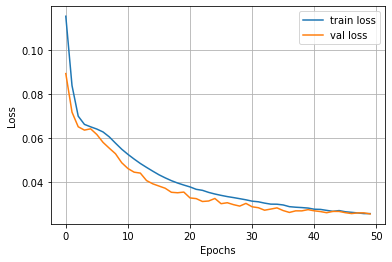

In [57]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('loss2.png')
plt.show()

In [28]:
import pandas as pd
d = {'train': history.history['loss'], 'val_loss': history.history['val_loss']}
df = pd.DataFrame(data=d)
df.to_csv('FRF_model_report/final_loss.csv',index=False)

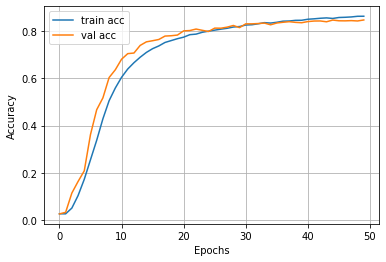

In [58]:
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.savefig('acc2.png')
plt.show()


In [29]:
d = {'train_acc': history.history['acc'], 'val_acc': history.history['val_acc']}
df = pd.DataFrame(data=d)
df.to_csv('FRF_model_report/final_acc.csv',index=False)

In [30]:
model.save('FRF_model_report/final')

2022-05-20 10:11:36.103630: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: FRF_model_report/final/assets


In [24]:
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('FRF_model_report/final')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 99, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [25]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)



In [26]:
y_pred = np.argmax(new_model.predict(test_audio), axis=1)
y_true = np.argmax(test_labels, axis=1)

2022-05-22 16:25:59.479751: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 335916000 exceeds 10% of free system memory.
2022-05-22 16:25:59.691068: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 335916000 exceeds 10% of free system memory.
2022-05-22 16:26:00.833150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-05-22 16:26:01.703638: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 16:26:01.704782: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 16:26:01.704853: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-22 16:26:01.705456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 16:26:01.705634: W

In [27]:
from sklearn.metrics import confusion_matrix,classification_report

print("\n")
print("\n")
print(classification_report(y_true,y_pred))





              precision    recall  f1-score   support

           0       0.78      0.90      0.83       154
           1       0.75      0.88      0.81       157
           2       0.76      0.83      0.79       161
           3       0.85      0.86      0.85       163
           4       0.78      0.85      0.81       144
           5       0.86      0.85      0.86       154
           6       0.81      0.79      0.80       138
           7       0.64      0.75      0.69       165
           8       0.83      0.73      0.78       153
           9       0.75      0.90      0.82       146
          10       0.91      0.75      0.82       162
          11       0.90      0.85      0.88       134
          12       0.84      0.90      0.87       136
          13       0.88      0.83      0.85       151
          14       0.86      0.65      0.74       158
          15       0.85      0.81      0.83       144
          16       0.79      0.87      0.83       151
          17       0.77

In [ ]:

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       154
           1       0.75      0.88      0.81       157
           2       0.76      0.83      0.79       161
           3       0.85      0.86      0.85       163
           4       0.78      0.85      0.81       144
           5       0.86      0.85      0.86       154
           6       0.81      0.79      0.80       138
           7       0.64      0.75      0.69       165
           8       0.83      0.73      0.78       153
           9       0.75      0.90      0.82       146
          10       0.91      0.75      0.82       162
          11       0.90      0.85      0.88       134
          12       0.84      0.90      0.87       136
          13       0.88      0.83      0.85       151
          14       0.86      0.65      0.74       158
          15       0.85      0.81      0.83       144
          16       0.79      0.87      0.83       151
          17       0.77      0.83      0.80       140
          18       0.93      0.83      0.88       155
          19       0.93      0.80      0.86       155
          20       0.91      0.87      0.89       159
          21       0.79      0.89      0.84       130
          22       0.76      0.83      0.79       145
          23       0.87      0.96      0.91       137
          24       0.90      0.84      0.87       154
          25       0.88      0.82      0.85       147
          26       0.89      0.86      0.87       127
          27       0.92      0.71      0.80       170
          28       0.70      0.88      0.78       143
          29       0.82      0.78      0.80       162
          30       0.87      0.87      0.87       152
          31       0.95      0.86      0.90       143
          32       0.68      0.83      0.75       149
          33       0.91      0.85      0.88       162
          34       0.93      0.74      0.82       149

    accuracy                           0.83      5250
   macro avg       0.84      0.83      0.83      5250
weighted avg       0.84      0.83      0.83      5250

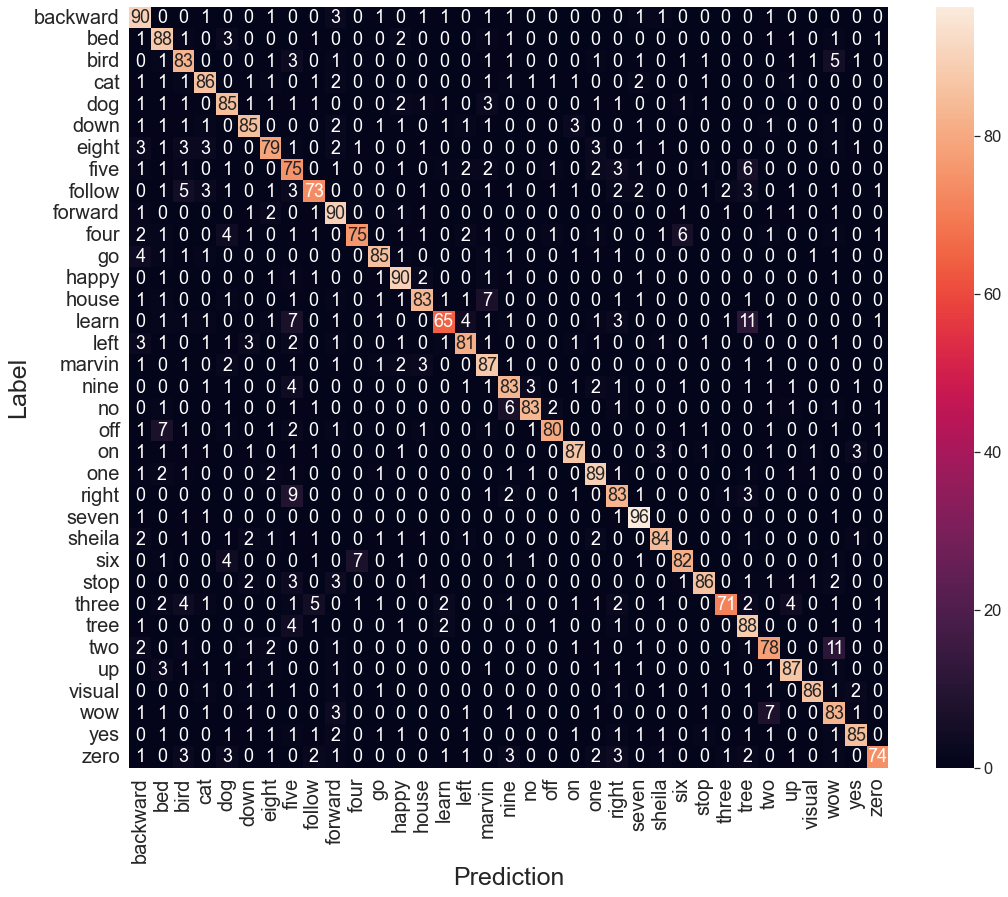

In [28]:
from sklearn.metrics import confusion_matrix

commands = ['backward','bed','bird','cat','dog','down','eight','five','follow',
 'forward','four','go','happy','house','learn','left','marvin',
 'nine', 'no', 'off', 'on', 'one', 'right', 'seven','sheila','six','stop',
 'three', 'tree', 'two', 'up', 'visual','wow','yes','zero']

confusion_matrix=confusion_matrix(y_true, y_pred)
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]*100
plt.figure(figsize=(17, 14))
sns.set(font_scale=1.5)

res=sns.heatmap(confusion_matrix,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='.0f')
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 20)

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20, rotation=90)
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Label', fontsize=25)
plt.savefig('conf.png')
plt.show()

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
test_ds = test_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size)

In [24]:
### START CODE HERE ### (1 line)
preds = new_model.evaluate(test_ds)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2022-05-20 10:16:07.246140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


 1/83 [..............................] - ETA: 2:55 - loss: 0.0339 - acc: 0.8281

2022-05-20 10:16:08.124781: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 10:16:08.126021: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 10:16:08.126041: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-20 10:16:08.126615: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 10:16:08.126702: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


83/83 [==============================] - 5s 34ms/step - loss: 0.0298 - acc: 0.8270

Loss = 0.029790207743644714
Test Accuracy = 0.8270476460456848


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [34]:
%pwd

'/home/utente/Scrivania/Uni/HDA/project/Project spectro'

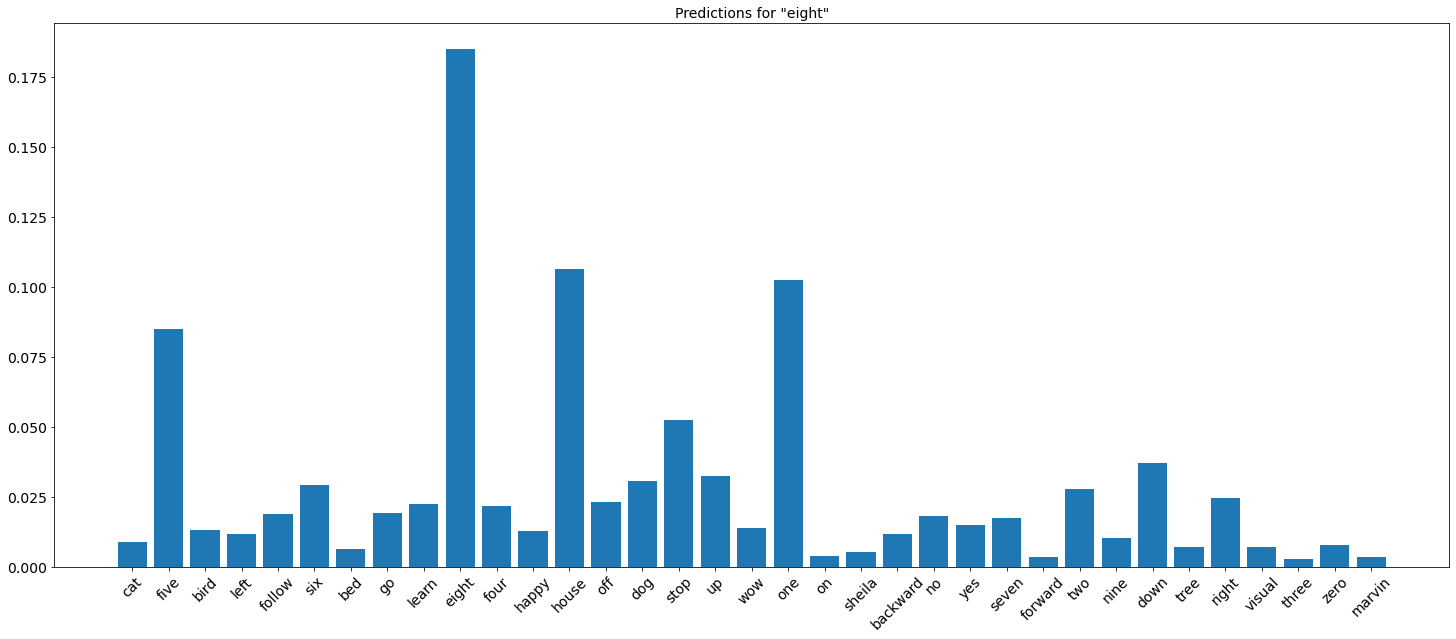

In [25]:
sample_file = data_dir/"follow/017c4098_nohash_0.wav"
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = new_model(spectrogram)
    prediction=np.array(prediction)
    prediction=np.reshape(prediction, len(commands))
    prediction=tf.nn.softmax(prediction)

    
    plt.figure(figsize=(25,10))
    plt.bar(commands, prediction)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.title(f'Predictions for "{commands[np.argmax(prediction)]}"', fontsize=14)
    
    plt.show()

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle's TensorFlow speech recognition challenge</a>.
- The 
<a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - Audio recognition using transfer learning codelab</a> teaches how to build your own interactive web app for audio classification.
- <a href="https://arxiv.org/abs/1709.04396" class="external">A tutorial on deep learning for music information retrieval</a> (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the <a href="https://librosa.org/" class="external">librosa</a> library—a Python package for music and audio analysis.